This is for using 4 channels, one brightfield and 3 fluorescent in the autoencoder.

### This is using compensated images
- Data directory: '/media/cjw/Data/cyto/mmFromTifs3/'
- Checkpoint directory;: "/media/cjw/Data/cyto/Checkpoints/2018-04-17-Chs-0-1-2-4_32_mmFromTifs3/checkpoint-2018-04-17-10-18-24/"
- Checkpoint file: 'autoencoder-256x-13980.meta'

In [1]:
import sys

In [2]:
sys.executable

'/home/cjw/anaconda3/envs/deep/bin/python'

In [3]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion
import os

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import hdbscan

from autoencoder import network
from autoencoder import utils

%matplotlib inline
%pwd

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'/media/cjw/PythonLib/cjwdeeplearning/autoencoder/AutoEncoder_Compensated'

In [4]:
tf.__version__

'1.8.0'

In [5]:
datadir =  '/media/cjw/Data/cyto/mmCompensatedTifs/'
#datadir =  '/media/cjw/Data/cyto/ChannelOne/'

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'

# cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-05-22-Denoise/checkpoint-2018-05-22-16-05-11/"
# aemeta = 'autoencoder-256x-56200.meta'
cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-06-04-512/checkpoint-2018-06-04-16-36-15/"
aemeta = 'autoencoder-512x-25290.meta'
if os.path.exists(cp_dir + aemeta):
    print("OK")

OK


In [ ]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()
                  
print(cp_dir)

if os.path.exists(cp_dir):
    print("OK, exists")
else:
    print("Oh no")
#checkpoint-2018-03-02-16-31-42/'
p_width = 32
p_height = 32
p_nchannels = 4
p_channels = [0,1,3,4]
p_nepochs = 40
p_batchsize = 128
p_learning_rate = 0.0002  #.00005
p_restore = False
p_latent_size = 512
p_droprate = 0.95
p_stdev = .04

enc_sizes = [(128, 3), (256, 3), (512, 3)] 
#enc_sizes = [(128, 3), (256, 3), (512,3), (1024,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
# enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
# dec_sizes = list(reversed(enc_sizes))

images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                      is_train=False, nfilters=dec_sizes)

loss, _, _ = network.ae_loss(images, sdd)

opt = network.model_opt(loss, p_learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


/media/cjw/Data/cyto/Checkpoints/2018-06-04-512/checkpoint-2018-06-04-16-36-15/
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
isize:  4 32
dh0 (?, 32, 32, 4)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)


In [8]:
#datadir = "/media/cjw/Data/cyto/mmFromTifs/"
#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_Ice.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish5_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish5_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_CCB.mm', '/media/cjw/Data/cyto/mmComp

dict_keys(['Fish3_CCB.mm', 'Fish4_ICE.mm', 'Fish3_Untreated.mm', 'Fish6_Untreated.mm', 'Fish2_Untreated.mm', 'Fish1_Ice.mm', 'Fish5_Untreated.mm', 'Fish6_ICE.mm', 'Fish4_CCB.mm', 'Fish6_CCB.mm', 'Fish2_CCB.mm', 'Fish1_Untreated.mm', 'Fish4_Untreated.mm', 'Fish2_ICE.mm', 'Fish5_CCB.mm', 'Fish3_ICE.mm', 'Fish1_CCB.mm', 'Fish5_ICE.mm'])

In [10]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    print(n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs
df = alldf.sample(frac=.025)
df = df.reset_index()
print(len(df))
df.tail()

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
4500


index  column   fid  field             file      id  \
4495  131865       0  1865      0        Fish2_ICE  131865   
4496   66076       0  6076      0  Fish5_Untreated   66076   
4497   92661       0  2661      0        Fish6_CCB   92661   
4498   69259       0  9259      0  Fish5_Untreated   69259   
4499  159090       0  9090      0        Fish3_ICE  159090   

                  mmfile  plate  row  well  xc  yc  treatment    run  
4495        Fish2_ICE.mm      0    0     0  32  32        ice  Fish2  
4496  Fish5_Untreated.mm      0    0     0  32  32  untreated  Fish5  
4497        Fish6_CCB.mm      0    0     0  32  32        ccb  Fish6  
4498  Fish5_Untreated.mm      0    0     0  32  32  untreated  Fish5  
4499        Fish3_ICE.mm      0    0     0  32  32        ice  Fish3

In [11]:
sns.set_style("whitegrid", {'axes.grid' : False})
len(df)

4500

(4500, 512) (4500, 32, 32, 4)
0.05694659426808357 0.9735199213027954


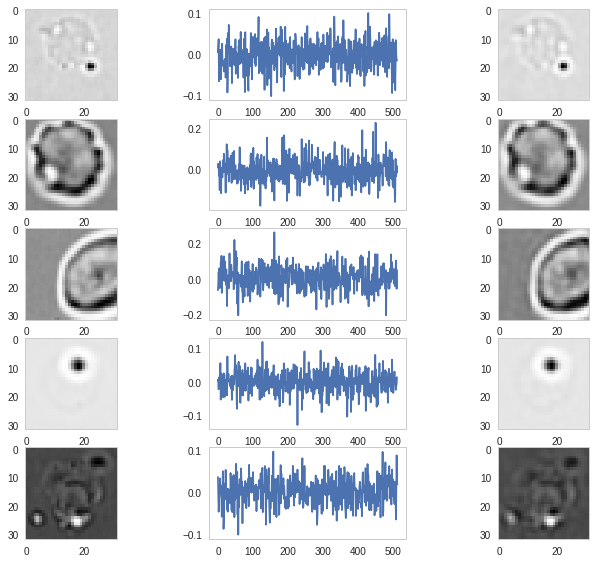

In [12]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    #print(ix)
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[ix,:,:,0])
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,3,i*3 + 3)
    plt.imshow(xdd[ix,:,:,0])
   

In [12]:
xhemm = np.memmap('/media/cjw/Data/cyto/latent_space_256.mm', dtype=np.float32, mode='w+', shape=xhe.shape)
xhemm[:] = xhe[:]
del xhemm

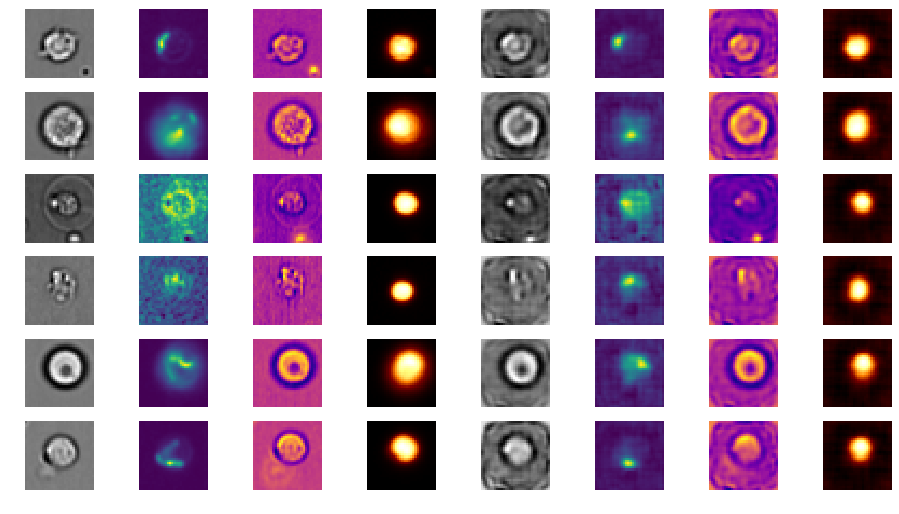

In [11]:
def one_imshow(image, r, c, ic, cmap):
    plt.subplot(16, 8, ic)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')

ic = 1

nrows = 6
plt.figure(figsize=(16,4*nrows))

for i in range(nrows):
    ix = np.random.randint(0, len(vv))
    one_imshow(vv[ix,:,:,0], nrows, 8, ic, 'gray')
    ic += 1
    
    one_imshow(vv[ix,:,:,1], nrows, 8, ic, 'viridis')
    ic += 1
    
    one_imshow(vv[ix,:,:,2], nrows, 8, ic, 'plasma')
    ic += 1
    
    one_imshow(vv[ix,:,:,3], nrows, 8, ic, 'afmhot')
    ic += 1
    
    one_imshow(xdd[ix,:,:,0], nrows, 8, ic, 'gray')
    ic += 1
    
    one_imshow(xdd[ix,:,:,1], nrows, 8, ic, 'viridis')
    ic += 1
    
    one_imshow(xdd[ix,:,:,2], nrows, 8, ic, 'plasma')
    ic += 1
    
    one_imshow(xdd[ix,:,:,3], nrows, 8, ic, 'afmhot')
    ic += 1

#plt.savefig('/media/cjw/Data/cyto/output/decoded.png')

In [13]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
4500
hek (4500, 512)
0 0 (4500, 512) (4500, 512)


(4500, 512)

In [ ]:
from sklearn.preprocessing import normalize
g_all = normalize(g_all, axis=1)

In [14]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] 10


In [15]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=64, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(4500, 64)
[0.0427819  0.03051316 0.02874535 0.02314994 0.02135234 0.01949151
 0.01853113 0.01787657 0.01653115 0.0161671  0.01530007 0.01400208
 0.01346516 0.01288367 0.01243497 0.01210003 0.01129669 0.01109867
 0.01068411 0.01021211 0.00997094 0.00932284 0.00926268 0.00892208
 0.00878879 0.00830645 0.00822271 0.00803685 0.0079406  0.0077814
 0.00752723 0.00734303 0.00717363 0.00709518 0.00698368 0.00664056
 0.00659327 0.00657511 0.00631077 0.00625607 0.00602915 0.00595971
 0.00588037 0.0057452  0.00562106 0.00550919 0.00532293 0.0052418
 0.00516544 0.00509249 0.00505071 0.00492854 0.00488122 0.00482953
 0.00481606 0.00478728 0.00466092 0.00461117 0.00450252 0.00447741
 0.00442969 0.00436061 0.00429351 0.00425755]
(64, 512)


In [16]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 30
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)
gmm = BayesianGaussianMixture(nclust, covariance_type='full')
gmm.fit(g_all)
gm = gmm.predict(g_all)

###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


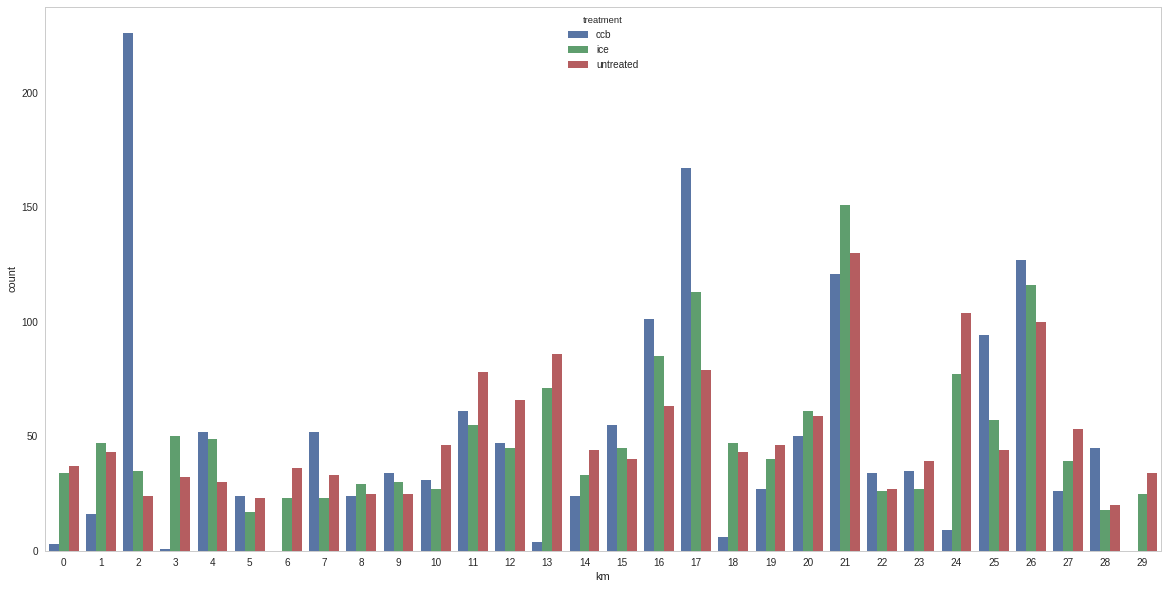

In [17]:
km = gm
df['km'] = km

plt.figure(figsize=(20,10))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='km', data=df, hue='treatment')

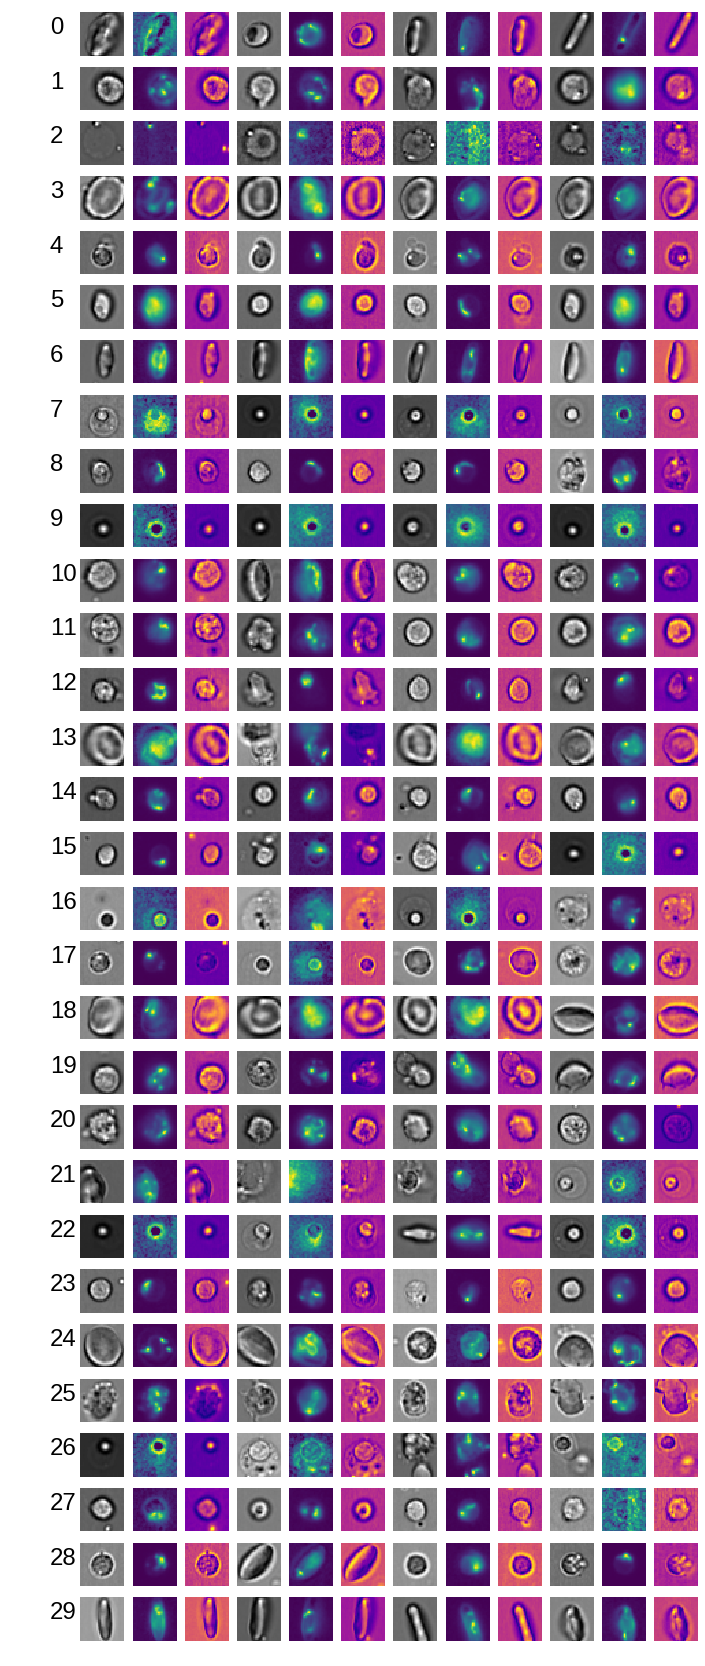

In [18]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['km'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[km == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='plasma')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


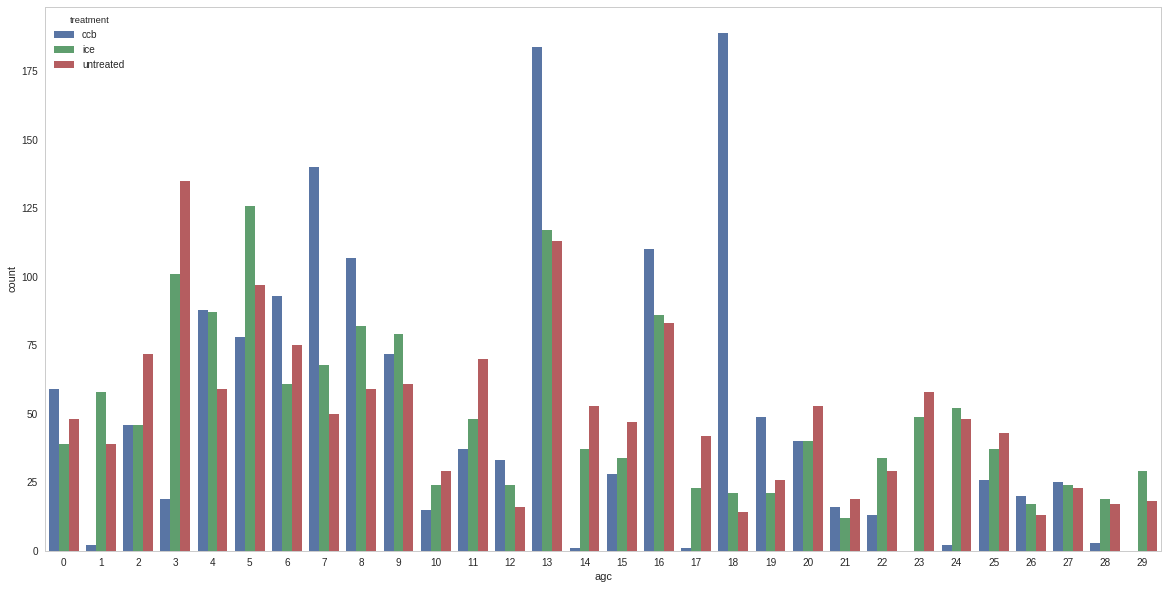

In [19]:
df['agc'] = agc
plt.figure(figsize=(20,10))
sns.countplot(x='agc', data=df, hue='treatment')
plt.savefig('/media/cjw/Data/cyto/output/agc_filedist.png')

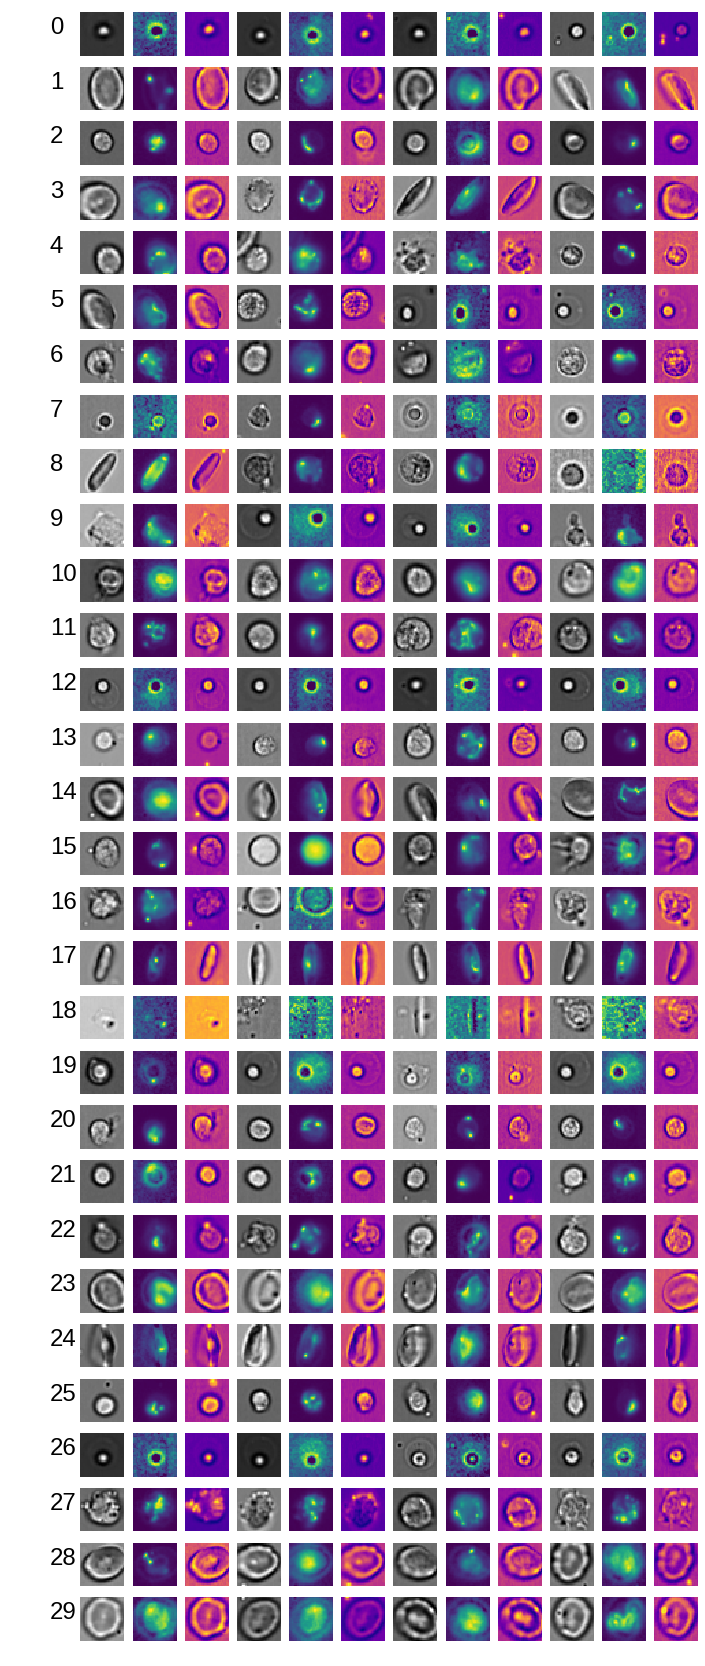

In [20]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='plasma')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1

-------------------------------------------------------------------------

In [19]:
import matplotlib 
def display_cluster(cluster_num, nrows=16, outfile=None):
    
    if outfile:
        plt.ioff()
    tn = cluster_num
    images4 = ximages[agc == tn]
    g4 = g_all[agc == tn]
    fig = plt.figure(figsize=(16,1.6*1.5*nrows))
    #print(images4.shape)

#     gtest = np.mean(g4, axis=0)
#     gtest = np.expand_dims(gtest.squeeze(), axis=0)
#     res = sess.run(sdd, feed_dict={enc:gtest})

#     gav = np.mean(g_all, axis=0)
#     gav = np.expand_dims(gav.squeeze(), axis=0)
#     resav = sess.run(sdd, feed_dict={enc:gav})

    ppi = 0
    for i in range(nrows):
        ix = np.random.randint(0, len(g4))
        plt.subplot(nrows,8,i*8 + 1)
        plt.imshow(images4[ix,:,:,0], cmap='gray')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 2)
        plt.imshow(images4[ix,:,:,1], cmap='viridis')
        plt.axis('off')

        plt.subplot(nrows,8, i*8 + 3)
        plt.imshow(images4[ix,:,:,2], cmap='plasma')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 4)
        plt.imshow(images4[ix,:,:,3], cmap='afmhot')
        plt.axis('off')

        plt.subplot(nrows, 2, i*2 + 2)
        plt.plot(g4[ix]*0, color='gray')
        plt.plot(g4[ix])

    #     plt.xticks([])
    #     plt.yticks([])
        plt.axis('off')
        ppi += 2
    if outfile:
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(4, 10)
        #fig.savefig('test2png.png', dpi=100)
        plt.savefig(outfile, dpi=100)
        plt.clf()
        plt.close(fig)
    
    plt.ion()



In [20]:
for i in range(nclust):
    outfile = "/media/cjw/Data/cyto/output/cluster_" + str(i).zfill(3) + ".png"
    display_cluster(i, 8, outfile=outfile)

In [39]:
from sklearn.manifold import TSNE

# geez = list()
# ceez = list()
# cindex = 0
# for i in (16,17, 18,19):
#     gna = g_all[agc == i]
#     ca = cindex #np.array(clist[cindex])
#     cna = np.repeat([i], gna.shape[0], axis=0)
#     geez.append(gna)
#     ceez.append(cna)
#     cindex += 1
# # c3 = gn3.shape[0]*(1, 0, 0)
# # c6 = gn3.shape[0]*(0, 1, 0)
# # c10 = gn3.shape[0]*(0, 0, 1)
# gn = np.concatenate(geez)
# cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
#print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=30).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)



(4500, 2)


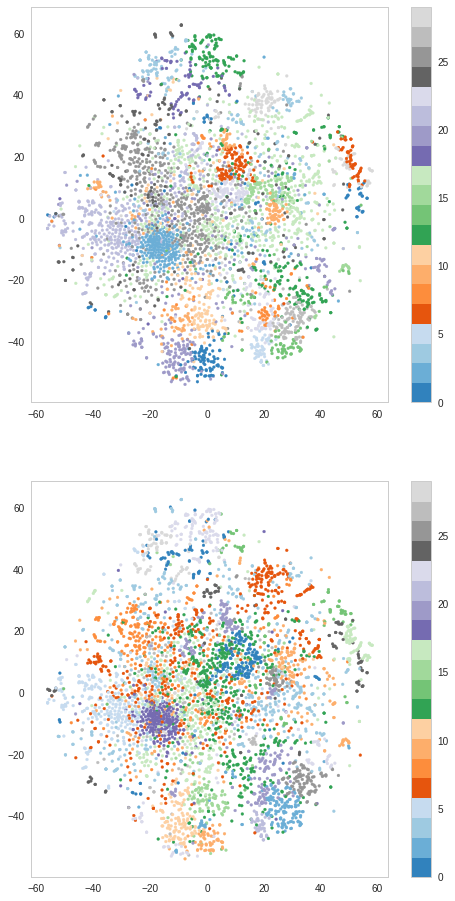

In [40]:
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)
plt.scatter(g_emb[:,0], g_emb[:,1], 8, gm, cmap='tab20c')
plt.colorbar()

# plt.subplot(4,1,2)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, gm1, cmap='tab20c')
# plt.colorbar()

plt.subplot(2,1,2)
plt.scatter(g_emb[:,0], g_emb[:,1], 8, agc, cmap='tab20c')
plt.colorbar()

# plt.subplot(4,1,4)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, km, cmap='tab20c')
# plt.colorbar()

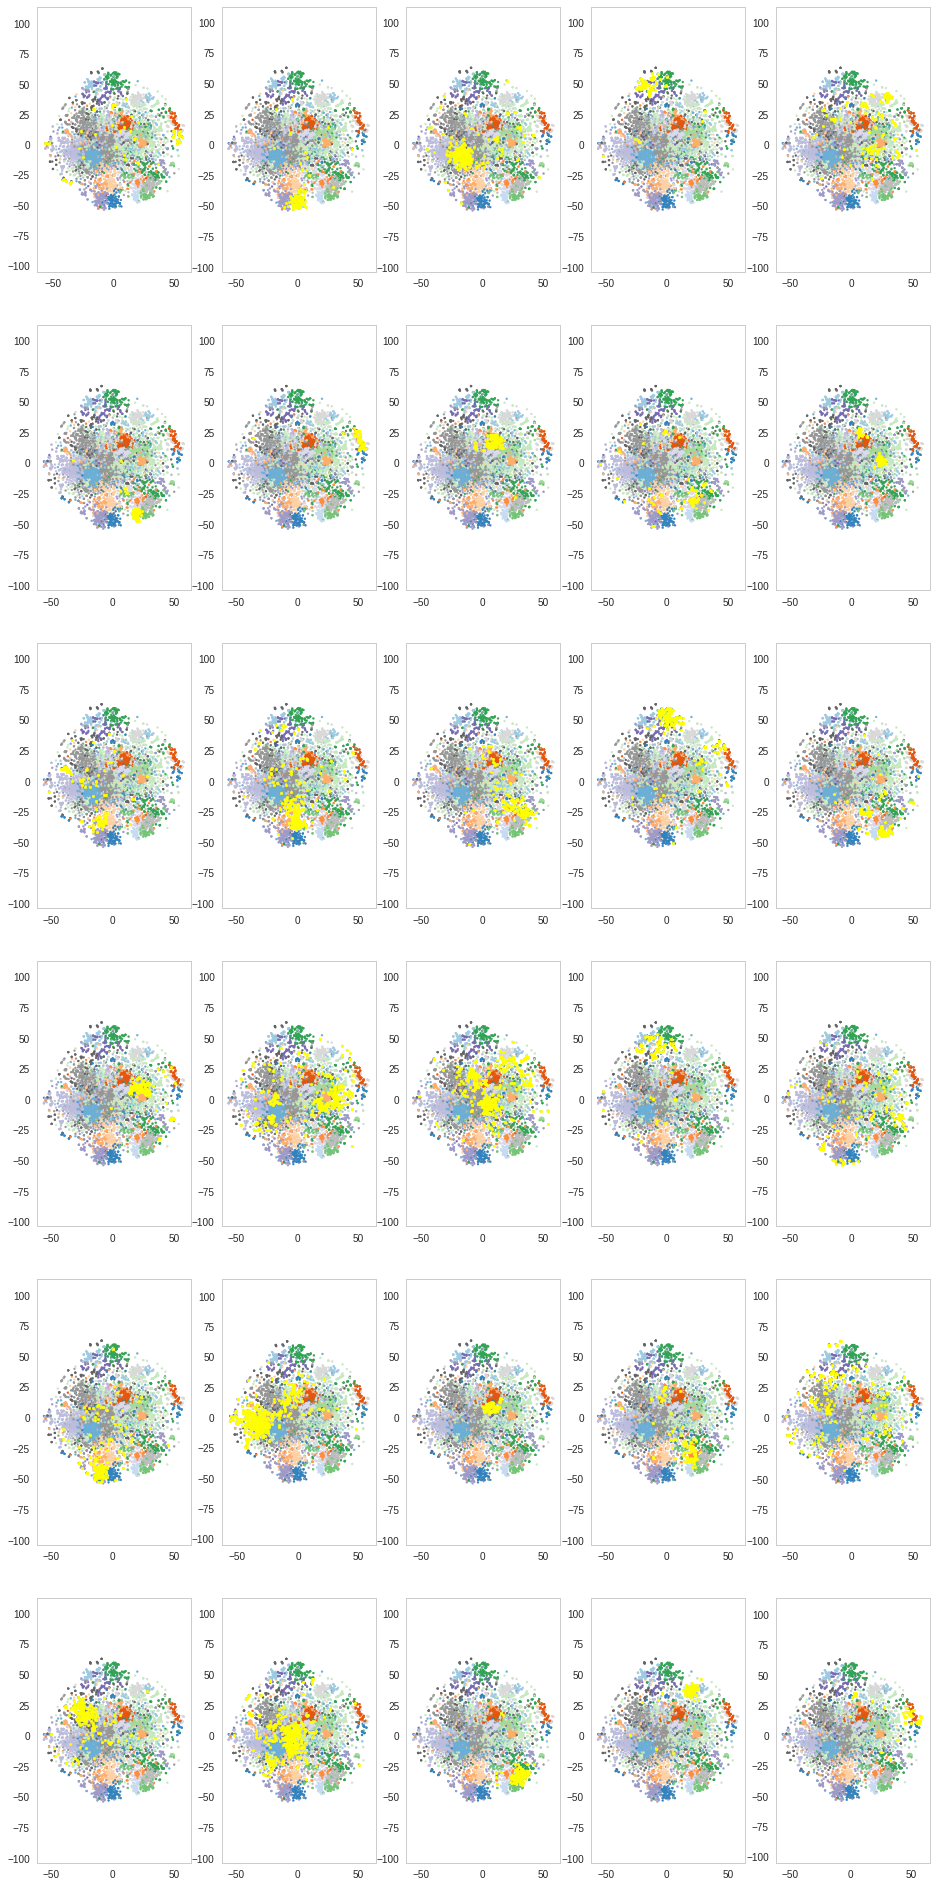

In [41]:
df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]
df['gm'] = gm
cs = ['black', 'gray', 'navy', 'blue',
      'slateblue', 'darkgreen', 'green', 'greenyellow',
     'gold', 'saddlebrown', 'salmon', 'orange']
ax = None

coi1 =  1
coi2 =  11
#plt.ioff()
plt.figure(figsize=(16,40))
for i in range(nclust):
        #ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color=gm, figsize=(6,6))
        ax = plt.subplot(nclust//4, 5, i + 1)
        plt.scatter(df['tsneX'], df['tsneY'], 4, gm, cmap='tab20c')
        xdf = df[df['gm'] == i]
        plt.scatter(xdf['tsneX'], xdf['tsneY'], label=i, s=8, color='yellow')
        ax.axis('equal')
        outfile = "/media/cjw/Data/cyto/output/tsne_" + str(i).zfill(3) + ".png"
        #plt.savefig(outfile, dpi=100)
        #plt.clf()
        #plt.close()
plt.ion()

In [33]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, cdist

dm =  np.arccos(1 -cdist(g_all,g_all, metric='cosine'))
#dm =  cdist(g_all, g_all, metric='euclidean')
#dm = distance_matrix(mma, mma)
print(dm.shape)

ddict = dict()
for i in range(g_all.shape[0]):
    ri = np.argsort(dm[i])
    ddict[i] = ri[1:13]

dm[1,ddict[1]]

(4500, 4500)


array([0.87735316, 0.90675051, 0.94599397, 0.98557653, 1.04937552,
       1.07830538, 1.07861352, 1.08901345, 1.09813778, 1.11247818,
       1.1203855 , 1.12410444])

In [37]:
from sklearn.metrics import silhouette_score, calinski_harabaz_score

sc = silhouette_score(dm, labels=gm, metric='precomputed', sample_size=None)
ch = calinski_harabaz_score(g_all[:,0:64], gm)
sc, ch

(0.021185451247299727, 27.63846602286204)